# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

#### Our Team:<br>1. Srinath Dittakavi<br>2. Kyle Burgin<br>3. Waleed Karshe<br>

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [45]:
#  pip install tensorflow_decision_forests

In [46]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

In [47]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.4.0


# Load the Dataset

In [48]:
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [50]:
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [51]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


## Pie chart for label column: Class

<Axes: ylabel='Class'>

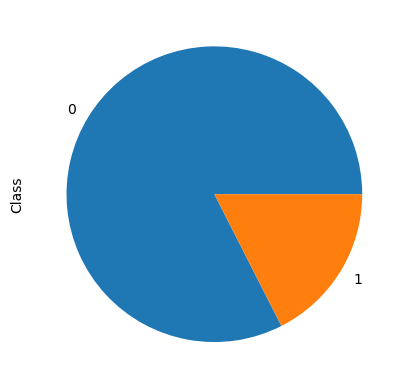

In [52]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

In [53]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

Let us now plot the first 6 numerical columns and their values using bar charts.

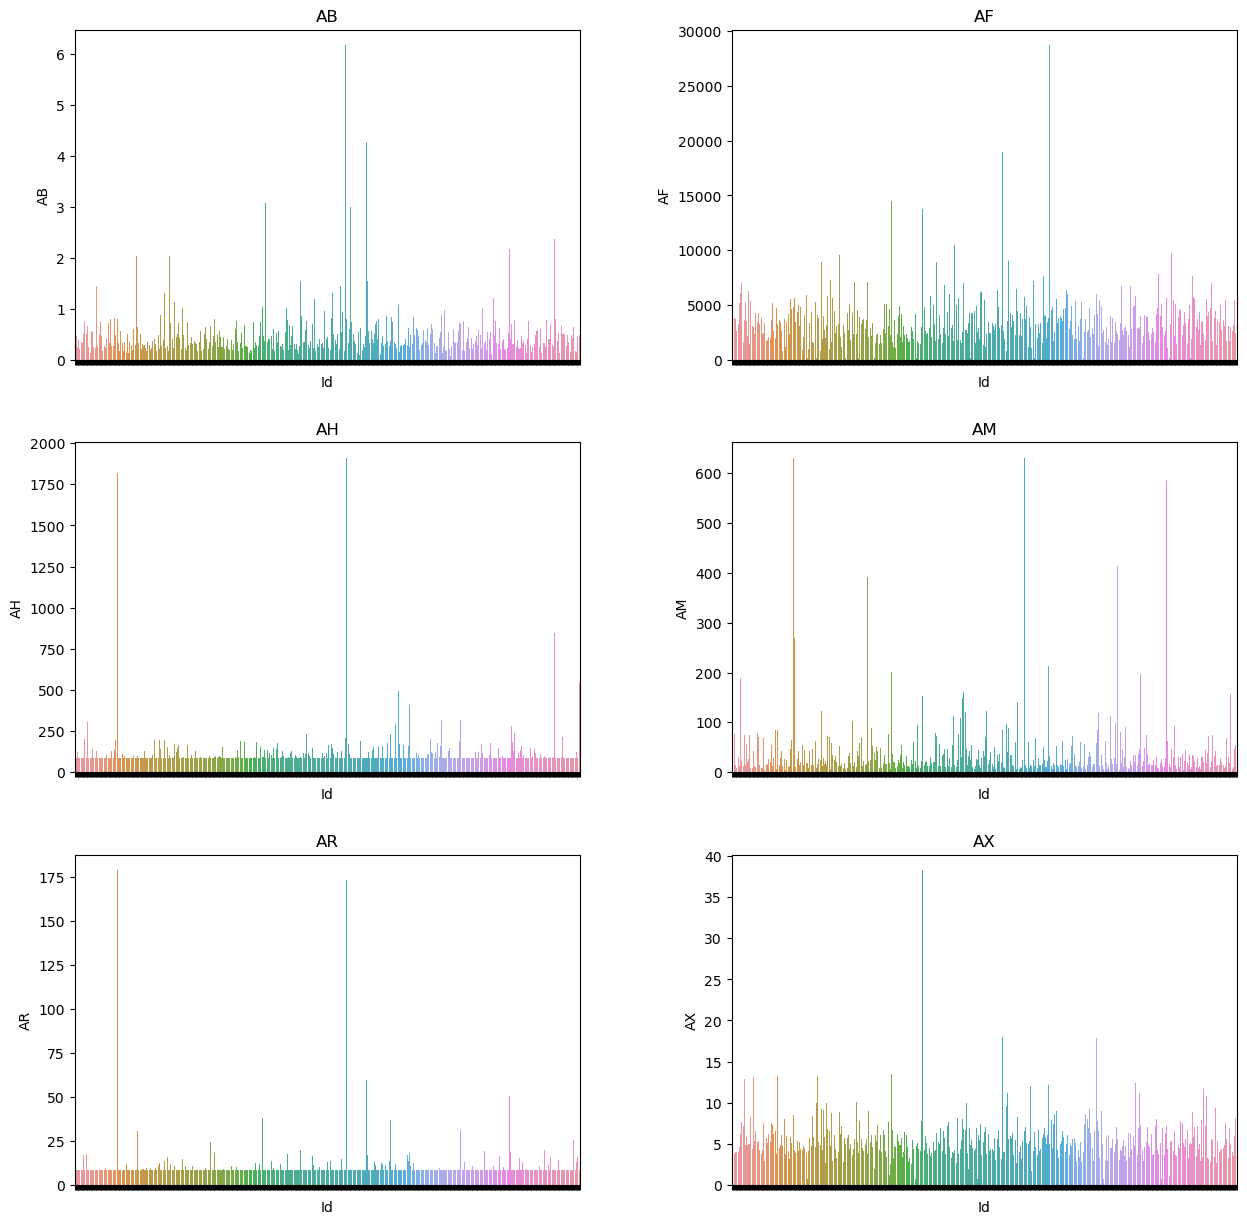

In [54]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [55]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

Now let us split the dataset into training and testing datasets:

# KFold validation

We will use KFold cross validation for training this model since the normal train/test split training won't be enough to acheive decent score.

We will split the dataset into 5 consecutive folds. Each fold is then used once as a validation set while the 4 (5-1) remaining folds form the training set.

Read more about KFold [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [56]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

# Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named `oof` to store the predictions of the validation set during each fold.

In [57]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [58]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get a better score.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Hyperparameter tuning to avoid overfitting

Because of the smaller size of the dataset, it is likely that the model will overfit during training.
Numerous parameters, primarily `max_depth` and `num_trees` can be changed to fine-tune the model and prevent overfitting.

The attribute`max_depth` indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is `16`. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter `num_trees` from its default value(`300`).

You can set these parameters as follows:

```rf = tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)```

# Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's  by examining the`Class` column.

In [59]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

# Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

```
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1]
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)
```

# Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **Keras weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [60]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```model.fit(x=train_ds, class_weight=class_weight)```

# Train Random Forest Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [61]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index
        train_df = dataset_df.iloc[train_index]
        valid_df = dataset_df.iloc[valid_index]
        valid_ids = valid_df.index.values

        # Select only feature columns for training.
        train_df = train_df[FEATURE_COLUMNS]
        valid_df = valid_df[FEATURE_COLUMNS]

        # There's one more step required before we can train the model.
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        # Note: Some column names contains white spaces at the end of their name,
        # which is non-comaptible with SavedModels save format.
        # By default, `pd_dataframe_to_tf_dataset` function will convert
        # this column names into a compatible format.
        # So you can safely ignore the warnings related to this.
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()
        rf.compile(metrics=["accuracy", "binary_crossentropy"])

        # Train the model
        # We will train the model using a one-liner.
        # Note: you may see a warning about Autograph.
        # You can safely ignore this, it will be fixed in the next release.
        # Previously calculated class weights is used to handle imbalance.
        rf.fit(x=train_ds, class_weight=class_weight)

        # Store the model
        models[f"fold_{i+1}"] = rf


        # Predict OOF value for validation data
        predict = rf.predict(x=valid_ds)

        # Store the predictions in oof dataframe
        oof.loc[valid_ids, 0] = predict.flatten()

        # Evaluate and store the metrics in respective dicts
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Use /tmp/tmpx108u6it as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.064045. Found 493 examples.
Training model...
Model trained in 0:00:00.267376
Compiling model...


[INFO 23-08-10 22:25:29.8857 UTC kernel.cc:1243] Loading model from path /tmp/tmpx108u6it/model/ with prefix 9c92bb4197314a43
[INFO 23-08-10 22:25:29.9413 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14268 node(s), and 56 input feature(s).
[INFO 23-08-10 22:25:29.9413 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-10 22:25:29.9414 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 459ms/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2182
##### Fold 2
Use /tmp/tmpgdmmviaz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.004087. Found 493 examples.
Training model...
Model trained in 0:00:00.257275
Compiling model...


[INFO 23-08-10 22:25:33.0110 UTC kernel.cc:1243] Loading model from path /tmp/tmpgdmmviaz/model/ with prefix f58abe9826aa463c
[INFO 23-08-10 22:25:33.0645 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13582 node(s), and 56 input feature(s).
[INFO 23-08-10 22:25:33.0646 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 389ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2608
##### Fold 3
Use /tmp/tmp6g86yfqh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.032903. Found 494 examples.
Training model...
Model trained in 0:00:00.252289
Compiling model...


[INFO 23-08-10 22:25:36.3662 UTC kernel.cc:1243] Loading model from path /tmp/tmp6g86yfqh/model/ with prefix 59766fcece5343e1
[INFO 23-08-10 22:25:36.4193 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13376 node(s), and 56 input feature(s).
[INFO 23-08-10 22:25:36.4193 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 364ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2741
##### Fold 4
Use /tmp/tmpnwnbf_g3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.029128. Found 494 examples.
Training model...
Model trained in 0:00:00.256939
Compiling model...


[INFO 23-08-10 22:25:38.9563 UTC kernel.cc:1243] Loading model from path /tmp/tmpnwnbf_g3/model/ with prefix 399b81f729a441f7
[INFO 23-08-10 22:25:39.0103 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13434 node(s), and 56 input feature(s).
[INFO 23-08-10 22:25:39.0104 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 374ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2717
##### Fold 5
Use /tmp/tmpo57jfdcn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.038754. Found 494 examples.
Training model...
Model trained in 0:00:00.267157
Compiling model...


[INFO 23-08-10 22:25:41.9573 UTC kernel.cc:1243] Loading model from path /tmp/tmpo57jfdcn/model/ with prefix 87f25dd72f3f4f40
[INFO 23-08-10 22:25:42.0133 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13980 node(s), and 56 input feature(s).
[INFO 23-08-10 22:25:42.0134 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-10 22:25:42.0134 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 382ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2172


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select any tree for display.

Let us pick one model from the `models` dict and select a tree for display.

In [62]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training, we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model. The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the `binary_crossentropy` evaluated on the out of bag dataset according to the number of trees in the model. Let us plot this for the models of each fold.

Note: Smaller values are better for this hyperparameter.

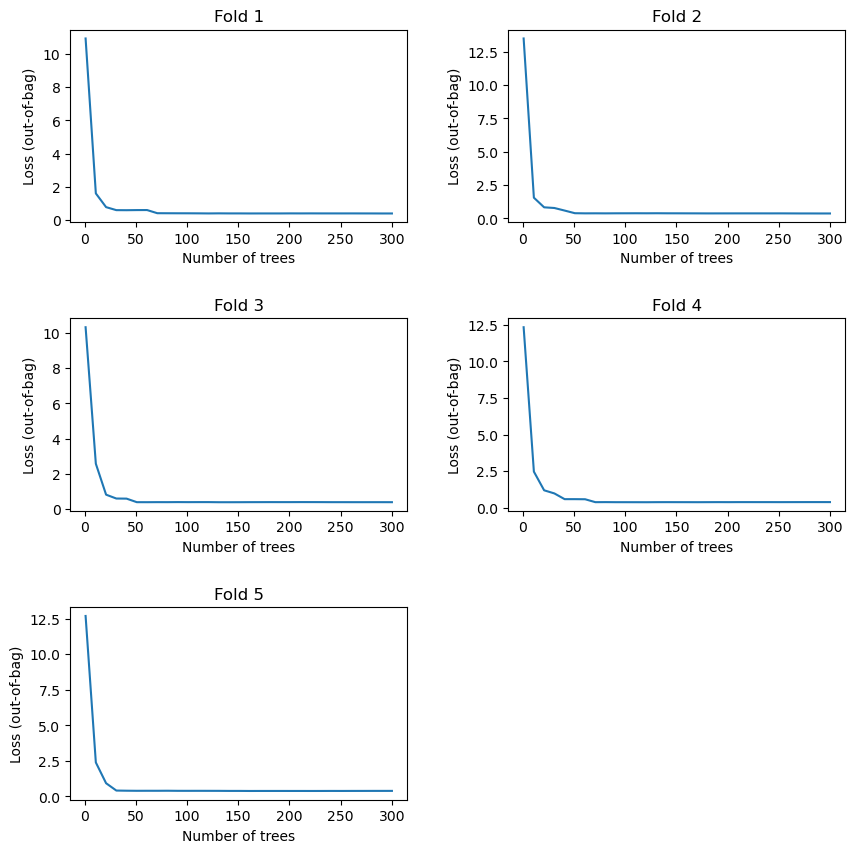

In [63]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

We can also see some general stats on the OOB dataset:

In [64]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=493, accuracy=0.83384120423487, loss=0.4011864148867133, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=493, accuracy=0.86791143186256, loss=0.374230902610848, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=494, accuracy=0.8625237360976467, loss=0.39912028399338717, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=494, accuracy=0.8742180068903357, loss=0.38689070260817593, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=494, accuracy=0.8477430594687857, loss=0.39049966583287166, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


Now, let us check the evaluation metrics for each fold and its average value.

In [65]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2182
fold_2: acc: 0.8790 loss: 0.2608
fold_3: acc: 0.9024 loss: 0.2741
fold_4: acc: 0.9024 loss: 0.2717
fold_5: acc: 0.9512 loss: 0.2172

Average accuracy: 0.9173  Average loss: 0.2484


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available `Variable Importances` for Decision Trees:

In [66]:
inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [67]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("DU" (1; #32), 47.0),
 ("DI" (1; #29), 25.0),
 ("DA" (1; #25), 21.0),
 ("AB" (1; #0), 19.0),
 ("FL" (1; #47), 19.0),
 ("GL" (1; #55), 18.0),
 ("BQ" (1; #12), 16.0),
 ("CR" (1; #21), 16.0),
 ("FD_" (1; #44), 16.0),
 ("CD_" (1; #17), 14.0),
 ("AF" (1; #1), 13.0),
 ("CC" (1; #16), 8.0),
 ("DF" (1; #27), 7.0),
 ("AR" (1; #4), 6.0),
 ("DH" (1; #28), 6.0),
 ("EB" (1; #35), 6.0),
 ("FI" (1; #46), 6.0),
 ("BC" (1; #8), 5.0),
 ("EH" (1; #38), 5.0),
 ("FR" (1; #48), 5.0),
 ("DE" (1; #26), 4.0),
 ("DL" (1; #30), 4.0),
 ("EE" (1; #36), 4.0),
 ("FE" (1; #45), 4.0),
 ("EU" (1; #42), 3.0),
 ("BN" (1; #10), 2.0),
 ("EL" (1; #40), 1.0)]

Visualization 1:

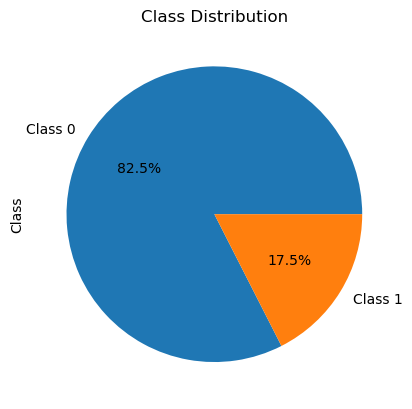

In [68]:
#Class Distribution Pie Chart
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie", labels=["Class 0", "Class 1"], autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

Visualization 2:

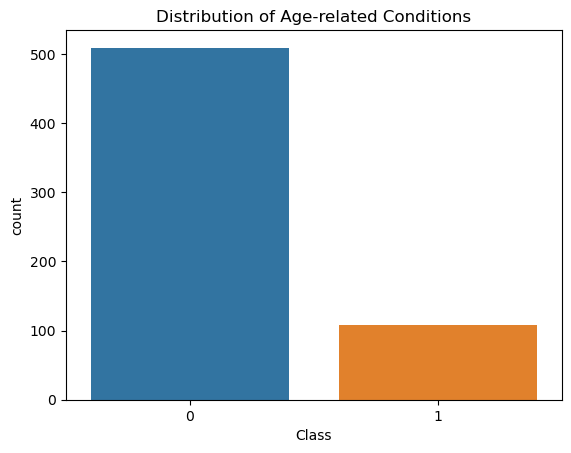

In [69]:
# Count plot for age-related conditions
sns.countplot(x='Class', data=dataset_df)
plt.title('Distribution of Age-related Conditions')
plt.show()


Visualization 3:

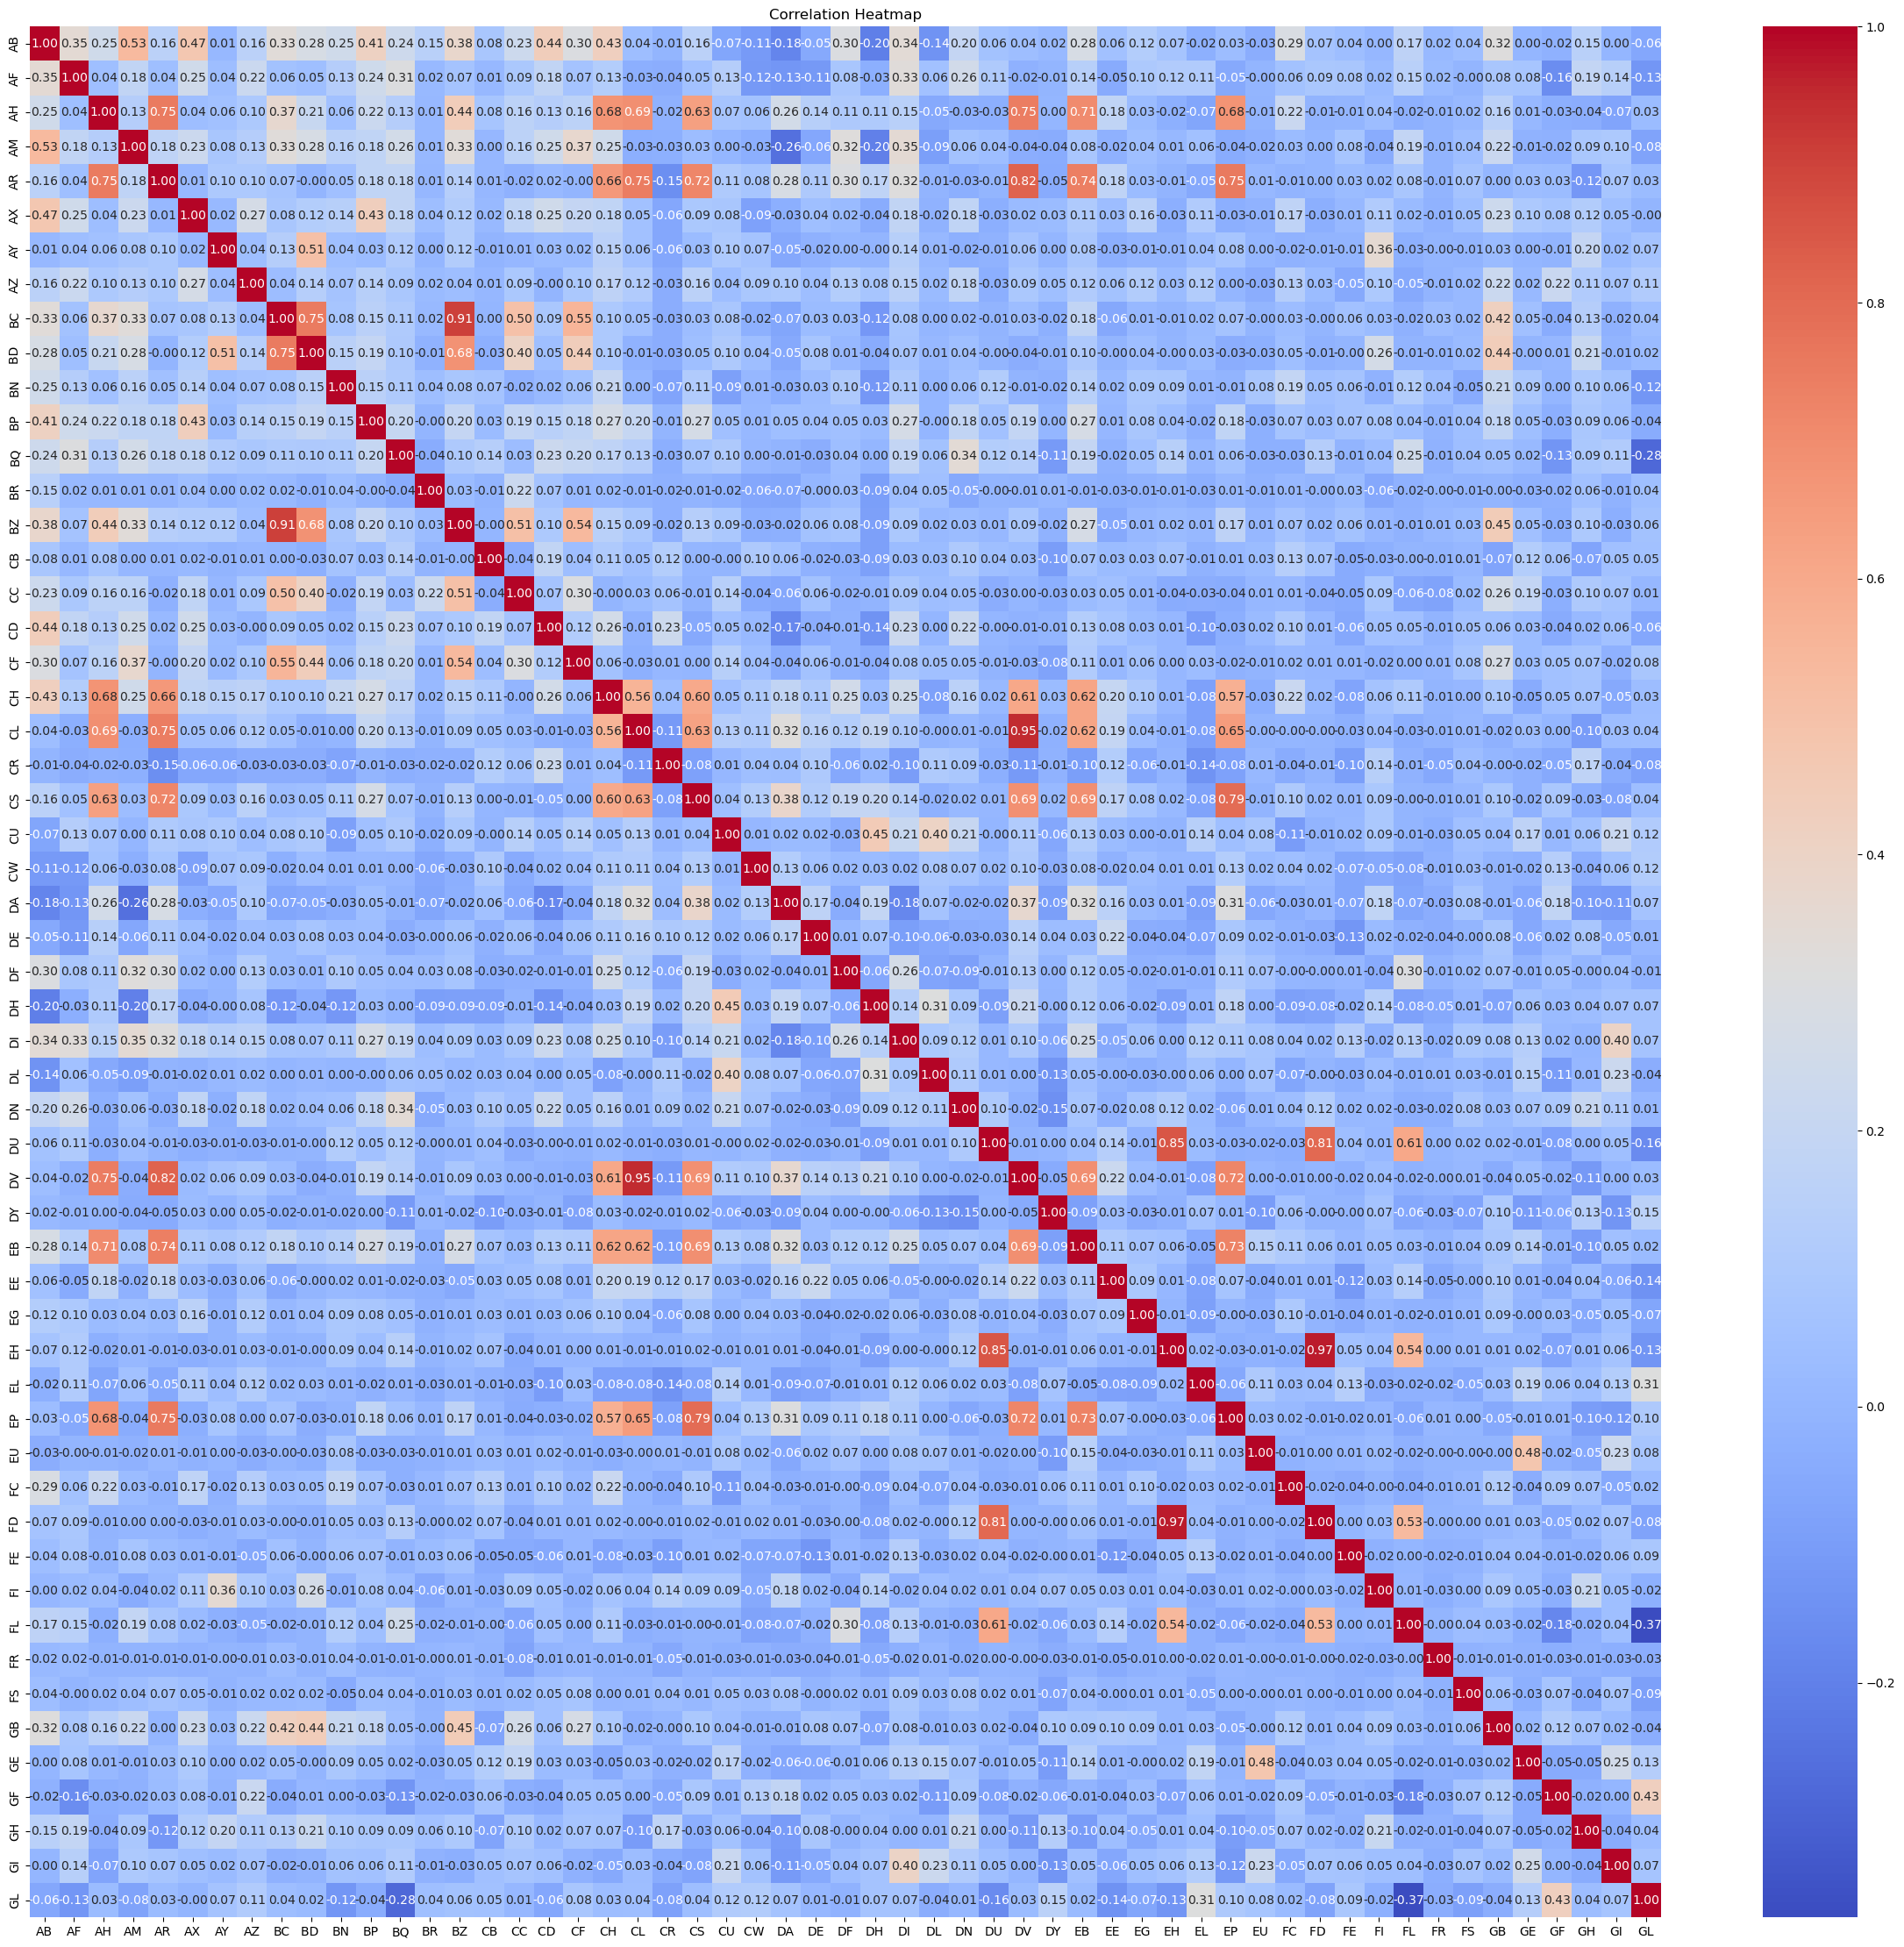

In [70]:
# Correlation heatmap
correlation_matrix = dataset_df[NUM_FEATURE_COLUMNS].corr()
plt.figure(figsize=(30, 28))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Visualization 4:

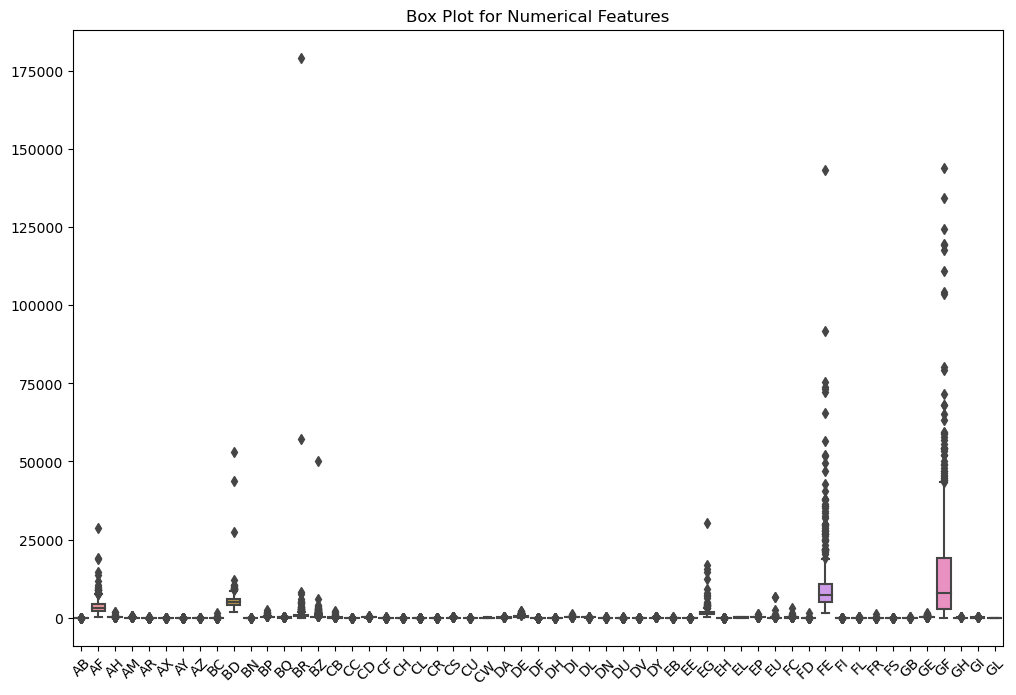

In [71]:
# Box plot for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset_df[NUM_FEATURE_COLUMNS])
plt.title('Box Plot for Numerical Features')
plt.xticks(rotation=45)
plt.show()

Feature selection and Feature Engineering:

/tmp/ipykernel_32/3915792727.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataset_df.corr()


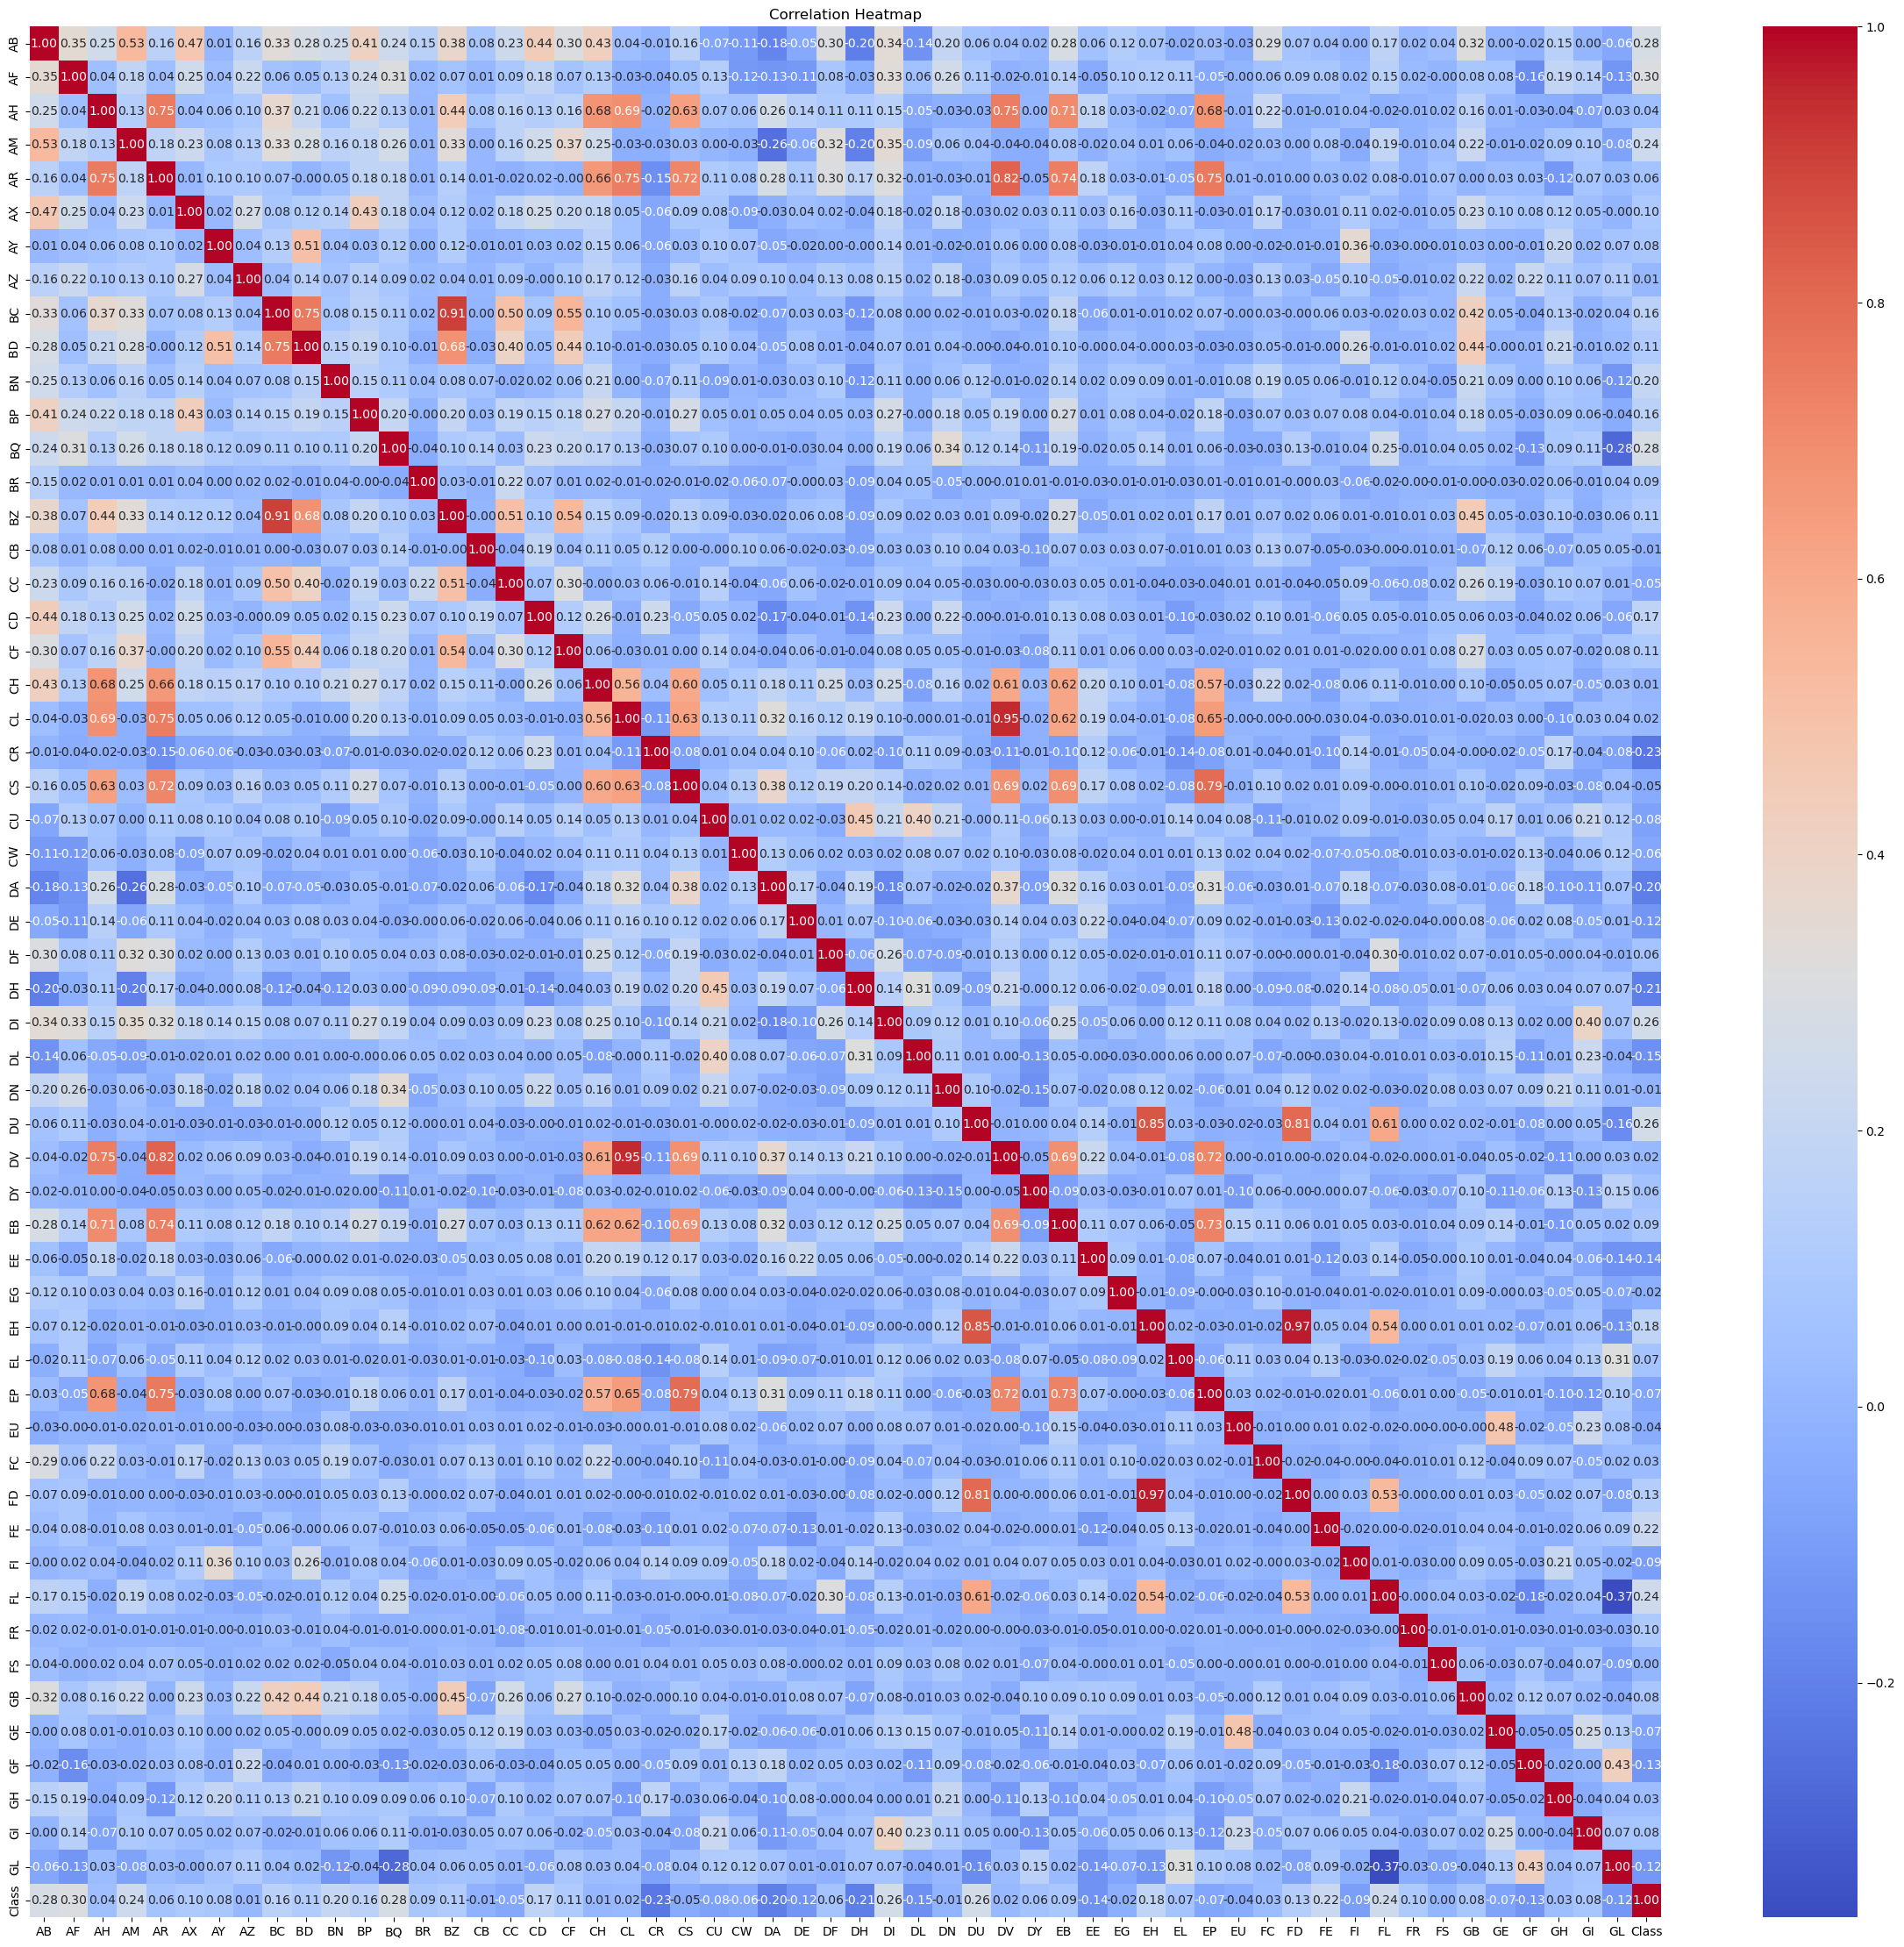

In [72]:
#Correlation Analysis:
correlation_matrix = dataset_df.corr()
plt.figure(figsize=(30, 28))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Model Selection and Training

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

label_encoder = LabelEncoder()
for col in FEATURE_COLUMNS:
    dataset_df[col] = label_encoder.fit_transform(dataset_df[col])

y = label_encoder.fit_transform(dataset_df['Class'])

encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(dataset_df[FEATURE_COLUMNS])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33)

three_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

for name, model in three_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    knnAcc= accuracy_score(y_test,y_pred) * 100
    knnAcc = round(knnAcc, 2)
    print("Accuracy: {knnAcc}%".format(knnAcc=knnAcc))
    models[f"fold_{i+1}"] = rf


Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        29

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204

Accuracy: 100.0%
Model: Random Forest
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       175
           1       0.00      0.00      0.00        29

    accuracy                           0.86       204
   macro avg       0.43      0.50      0.46       204
weighted avg       0.74      0.86      0.79       204

Accuracy: 85.78%
Model: SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        29

    accuracy                           1.00       204
   macro avg       1.00      1.00  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Submission

In [74]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
print("RandomForestModel")
predictions = models['fold_1'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)
print("Logistic Regression")
predictions = models['fold_2'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)
print("Random Forest")
predictions = models['fold_3'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)
print("SVM")
predictions = models['fold_4'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

RandomForestModel
1/1 [==============================] - 0s 137ms/step
[[0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643]]
Logistic Regression
1/1 [==============================] - 0s 137ms/step
[[0.69666687, 0.30333313], [0.69666687, 0.30333313], [0.69666687, 0.30333313], [0.69666687, 0.30333313], [0.69666687, 0.30333313]]
Random Forest
1/1 [==============================] - 0s 129ms/step
[[0.66333356, 0.33666644], [0.66333356, 0.33666644], [0.66333356, 0.33666644], [0.66333356, 0.33666644], [0.66333356, 0.33666644]]
SVM
1/1 [==============================] - 0s 129ms/step
[[0.63666692, 0.36333308], [0.63666692, 0.36333308], [0.63666692, 0.36333308], [0.63666692, 0.36333308], [0.63666692, 0.36333308]]


In [76]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)